The code uses the os module, which provides many functions for working with the operating system.

Command os.makedirs("/content/sample_data/kaggle/"): Creates a directory at the specified path. If the path already exists, this function does nothing. If the path does not exist, it will create all necessary intermediate directories. If neither directory exists, both will be created.
Command os.chdir("/content/sample_data/kaggle/"): Changes the current working directory of the process to the one specified. After running this command, all relative paths used in the code will refer to the new working directory /content/sample_data/kaggle/.

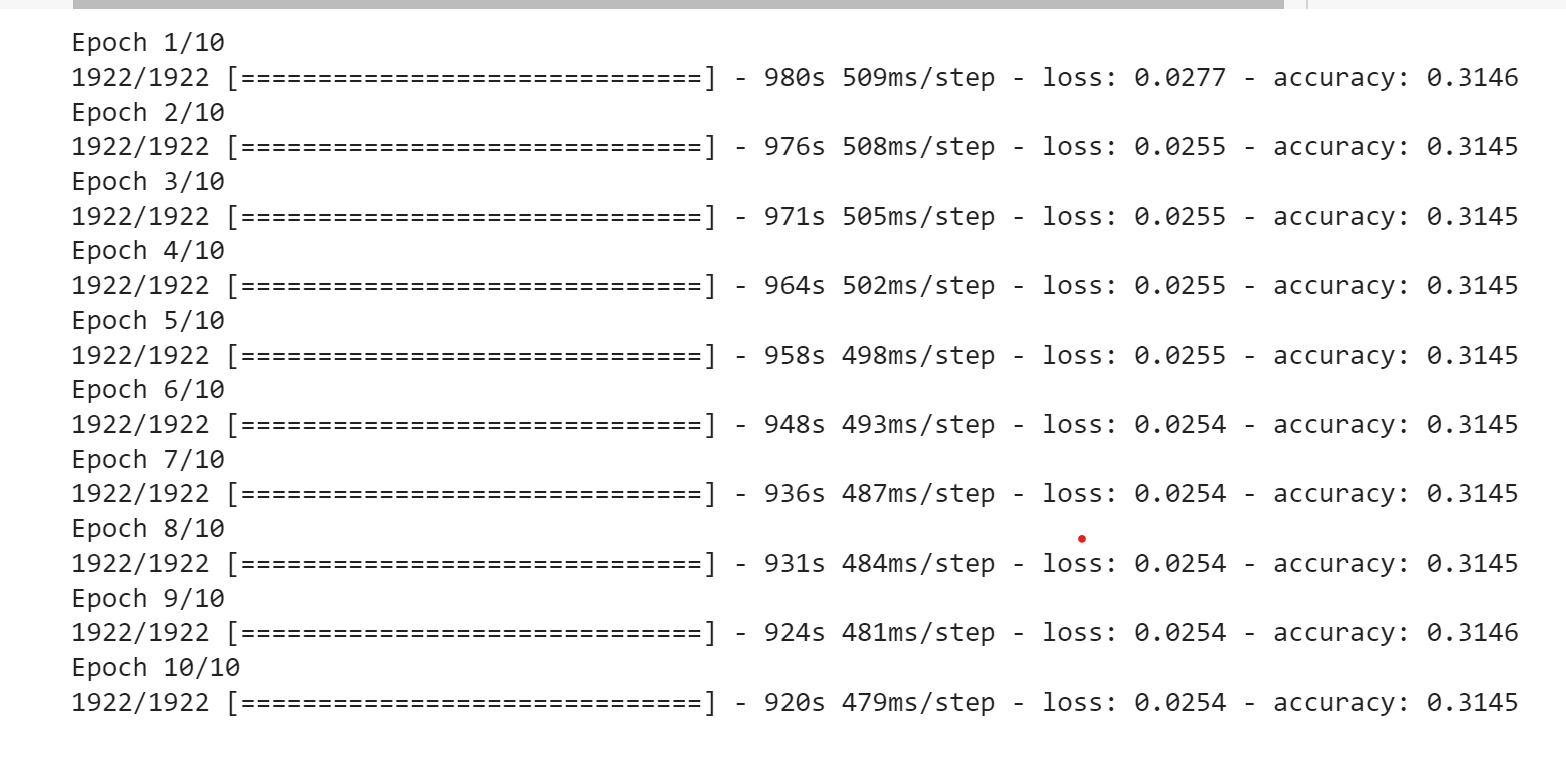In Google Colab:
/content/ is the root directory where files can be stored and accessed.
sample_data is a default directory in Colab that contains some sample datasets.
The commands above create a new kaggle subdirectory in /content/sample_data/ and navigate to it, for further work with Kaggle data or for downloading data from Kaggle.
This can be useful when using datasets from Kaggle and need to organize the files into appropriate directories within the Colab environment.

In [ ]:
import os

os.makedirs("/content/sample_data/kaggle/")
os.chdir("/content/sample_data/kaggle/")

This code is used in the Google Colab environment to mount Google Drive as a file system in the Colab notebook.

from google.colab import drive: Imports the drive module from the google.colab package. The module contains functions to interact with Google Drive in the Colab environment.

drive.mount('/content/drive'): Calls the mount function, which "mounts" Google Drive to the specified path ('/content/drive') in the file system of the virtual machine running Colab Notebook. This means that after mounting, you can access the files in your Google Drive directly from the Colab laptop, as if they were local files.
We will use this to load data to train machine learning models. and saving the results of data processing or machine learning models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The command is used to move data from Google Drive to Colab's local file system to conveniently work with the file further, such as unpacking, data analysis, model training, etc. Importantly, when the Colab session ends, the files in /content/sample_data/ will be deleted, so if you want to save your work, you'll need to save them back to Google Drive or download them locally.

In [ ]:
cp /content/drive/MyDrive/kaggle_dataset/breast-cancer-semantic-segmentation-bcss.zip /content/sample_data/kaggle/breast-cancer-semantic-segmentation-bcss.zip

cp: cannot stat '/content/drive/MyDrive/kaggle_dataset/breast-cancer-semantic-segmentation-bcss.zip': No such file or directory


In [ ]:
!unzip -x breast-cancer-semantic-segmentation-bcss.zip

unzip:  cannot find or open breast-cancer-semantic-segmentation-bcss.zip, breast-cancer-semantic-segmentation-bcss.zip.zip or breast-cancer-semantic-segmentation-bcss.zip.ZIP.


In [ ]:
os.remove("/content/sample_data/kaggle/breast-cancer-semantic-segmentation-bcss.zip")

n applications such as training a machine learning model for image segmentation, you often have a set of images and corresponding masks. Masks can indicate areas of interest in each image, such as identifying tumors in medical images. By using the glob module to obtain the paths to these images and masks, you can efficiently load and process them for tasks such as neural network training.

I use the Python glob module to find and list paths to files in certain directories that match a given pattern.

import glob: Imports the glob module, which provides a method to retrieve files/paths matching a given pattern.
image_paths = glob.glob(pathname="/content/sample_data/kaggle/BCSS/train/*.png"): This line searches for all files in /content/sample_data/kaggle/BCSS/train/ that have . png file extension.

In [ ]:
import glob

image_paths = glob.glob(pathname= "/content/sample_data/kaggle/BCSS/train/*.png")
mask_paths = glob.glob(pathname= "/content/sample_data/kaggle/BCSS/train_mask/*.png")

This code outlines the process of loading, processing, and training a U-Net model for image segmentation tasks, specifically designed to work with image and mask data, commonly used in medical imaging like detecting cancerous cells.


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Activation, BatchNormalization, Concatenate, Dropout

# Параметри   Parameters
image_size = (512, 512)
batch_size = 16  # You can set a smaller batch size if you have memory problem

# Функція для завантаження та перетворення зображень  Function to download and convert images
def load_images(image_paths, image_size):
    for image_path in image_paths:
        img = load_img(image_path, target_size=image_size, color_mode='rgb')
        img = img_to_array(img) / 255.0
        yield img

def load_masks(mask_paths, image_size):
    for mask_path in mask_paths:
        mask = load_img(mask_path, target_size=image_size, color_mode='grayscale')
        mask = img_to_array(mask) / 255.0
        yield mask

# Генератори  Generators
image_generator = load_images(image_paths, image_size)
mask_generator = load_masks(mask_paths, image_size)

# Функція, яка повертає партії даних для тренування   A function that returns batches of data for training
def train_generator(image_paths, mask_paths, batch_size, image_size):
    image_index = 0
    mask_index = 0

    while True:
        # Ініціалізація партії  Party initialization
        X_batch = np.zeros((batch_size, *image_size, 3), dtype=np.float32)
        y_batch = np.zeros((batch_size, *image_size, 1), dtype=np.float32)

        # Цикл для формування партії   Party formation cycle
        for i in range(batch_size):
            # Повторення списку зображень, якщо досягнуто кінця  Repeat the list of images if the end is reached
            if image_index == len(image_paths):
                image_index = 0
            if mask_index == len(mask_paths):
                mask_index = 0

            # Завантаження та обробка зображення та маски  Image and mask loading and processing
            img = load_img(image_paths[image_index], target_size=image_size, color_mode='rgb')
            mask = load_img(mask_paths[mask_index], target_size=image_size, color_mode='grayscale')

            X_batch[i] = img_to_array(img) / 255.
            y_batch[i] = img_to_array(mask) / 255.

            # Інкрементація індексів Index incrementation
            image_index += 1
            mask_index += 1

        yield X_batch, y_batch

# Тепер використовуйте оновлену функцію генератора  Now use the updated generator feature
train_gen = train_generator(image_paths, mask_paths, batch_size, image_size)

# Побудова моделі U-Net   Construction of the U-Net model
def simple_unet_model(input_size=(512, 512, 3)):
    inputs = Input(input_size)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    u2 = UpSampling2D((2, 2))(c2)
    u2 = Concatenate()([u2, c1])
    c6 = Conv2D(16, (3, 3), activation='relu', padding='same')(u2)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(16, (3, 3), activation='relu', padding='same')(c6)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c6)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Визначення моделі   Model definition
model = simple_unet_model(input_size=(512, 512, 3))

# Компіляція моделі  Compilation of the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Тренування моделі  Model training
history = model.fit(train_gen, steps_per_epoch=len(image_paths)//batch_size, epochs=10)


Epoch 1/10
1922/1922 [==============================] - 980s 509ms/step - loss: 0.0277 - accuracy: 0.3146
Epoch 2/10
1922/1922 [==============================] - 976s 508ms/step - loss: 0.0255 - accuracy: 0.3145
Epoch 3/10
1922/1922 [==============================] - 971s 505ms/step - loss: 0.0255 - accuracy: 0.3145
Epoch 4/10
1922/1922 [==============================] - 964s 502ms/step - loss: 0.0255 - accuracy: 0.3145
Epoch 5/10
1922/1922 [==============================] - 958s 498ms/step - loss: 0.0255 - accuracy: 0.3145
Epoch 6/10
1922/1922 [==============================] - 948s 493ms/step - loss: 0.0254 - accuracy: 0.3145
Epoch 7/10
1922/1922 [==============================] - 936s 487ms/step - loss: 0.0254 - accuracy: 0.3145
Epoch 8/10
1922/1922 [==============================] - 931s 484ms/step - loss: 0.0254 - accuracy: 0.3145
Epoch 9/10
1922/1922 [==============================] - 924s 481ms/step - loss: 0.0254 - accuracy: 0.3146
Epoch 10/10
1922/1922 [=======================

Save training model

In [ ]:
# Зберегти модель на Google Drive   Save the model to Google Drive
#model.save('/content/drive/MyDrive/SavingsOfTrainingModels/cancer_predict_trainigs.h5') # або 'my_model' для SavedModel формату